# Single Peak Simulations

In this set of simulations, we will test power spectrum parameterization performance on power spectra simulated with a single peak.

This simulation test checks the use case of identifying and quantifying the dominant peak in a power spectrum.

To do so, we will simulate power spectra with a single peak with an aperiodic component in 'fixed' mode, all with varying parameters.

Performance will be evaluated by examining how well the algorithm can reconstruct periodic and aperiodic parameters for the simulated power spectra.

In [1]:
%matplotlib inline

In [2]:
from os.path import join as pjoin

import numpy as np
from scipy.stats import spearmanr

from fooof import FOOOFGroup, fit_fooof_3d
from fooof.sim import gen_group_power_spectra
from fooof.sim.utils import set_random_seed

In [3]:
# Import project specific (local) custom code
import sys
sys.path.append('../code')
from plts import *
from sims import *
from utils import *
from analysis import *
from settings import *

## Settings

In [4]:
# Set random seed
set_random_seed(303)

In [5]:
# Set plotting style from seaborn
import seaborn as sns
sns.set_style('white')

In [6]:
# Set a folder name (for saving data & figures)
FOLDER = '01_one-peak/'

In [7]:
# Analysis Settings
SAVE_FIG = False
GEN_SIMS = False
SAVE_SIMS = False

## Simulation Tests: One Peak Across Noise Levels

First, simulate power spectra with one peak, and measure how well we can reconstruct each variable.

### Simulate Power Spectra

In [8]:
# Set the number of power spectra - this is per noise condition
n_psds = N_PSDS

# Use generators to sample peak & aperiodic parameters
peaks = gen_peak_def(1)
aps = gen_ap_def()

In [9]:
# Get data sizes
n_nlvs = len(NLVS)
n_freqs = int((F_RANGE[1] - F_RANGE[0]) / F_RES + 1)

In [10]:
# Generate or load power spectra
data_name = 'single_peak_sims'

if GEN_SIMS:
    
    # Initialize data stores
    psds = np.empty(shape=[n_nlvs, n_psds, n_freqs])
    sim_params = [None] * n_nlvs

    # Generate simulated power spectra
    for n_ind, nlv in enumerate(NLVS):
        freqs, psds[n_ind, :, :], sim_params[n_ind] = \
            gen_group_power_spectra(n_psds, F_RANGE, aps, peaks, nlv,
                                    F_RES, return_params=True)
    
    # Save out generated simulated data & parameter definitions
    if SAVE_SIMS:
        save_sim_data(pjoin(FOLDER, data_name), freqs, psds, sim_params)

else:
    # Reload simulated data and parameter definitions
    freqs, psds, sim_params = load_sim_data(pjoin(FOLDER, data_name))
    
# Check shape
print('n_nlvs, n_spectra, n_freqs : ', psds.shape)

n_nlvs, n_spectra, n_freqs :  (5, 1000, 153)


In [11]:
# Extract ground truth values
peak_truths, ap_truths = get_ground_truth(sim_params)

##### Check the empirical levels of noise expected  (empirical noise floor)

The empirical noise levels should be the same as the noise scaling factor set in the simulations.

This is just a check, to estimate the actual error off the simulations. 

Note that the noise values also determine the amount of variance that can be expected to be captured by fitting.

If parameterization captures more variance than expected given the amount of simulated noise, this suggests the algorithm is overfitting. 

In [34]:
emp_nlv = []
for nlv in NLVS:
    temp = []

    # Within each noise level, get the average squared 'error'
    for it in range(n_psds):
        temp.append(np.mean(np.random.normal(0, nlv, len(freqs))**2))
    
    # Get the average 'error' per noise level
    emp_nlv.append(np.mean(temp))

In [13]:
# Compare simulated values to empirical values
print('Simulated NLV Values:')
print_list(NLVS)
print('Empirical NLV Values:')
print_list(np.sqrt(emp_nlv))

Simulated NLV Values:
['0.0000', '0.0250', '0.0500', '0.1000', '0.1500']
Empirical NLV Values:
['0.0000', '0.0251', '0.0500', '0.1000', '0.1500']


### Fit Power Spectra with FOOOF

In [14]:
# Initialize FOOOFGroup to test with
fg = FOOOFGroup(*FOOOF_SETTINGS, verbose=False)

# Print out settings used for fitting simulated power spectra
fg.print_settings()

                                                                                                  
                                         FOOOF - SETTINGS                                         
                                                                                                  
                                    Peak Width Limits : [1, 8]                                    
                                     Max Number of Peaks : 6                                      
                                    Minimum Peak Height : 0.1                                     
                                       Peak Threshold: 2.0                                        
                                      Aperiodic Mode : fixed                                      
                                                                                                  


In [15]:
# Fit power spectra - same FOOOF settings across each group of simulated power spectra
fgs = fit_fooof_3d(fg, freqs, psds)

In [16]:
# # Alternatively:
# # Fit power spectra - adapting FOOOF settings for each group of simulated power spectra
# fgs = []
# for nlv, nlv_psds in zip(nlvs, psds):
#     fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6, min_peak_height=5*nlv)
#     fg.fit(freqs, nlv_psds)
#     fgs.append(fg.copy())

### Extract FOOOF fit Data

In [17]:
# Extract data of interest from FOOOF fits
peak_fits, ap_fits, err_fits, r2_fits, n_fit_peaks = get_fit_data(fgs)

In [18]:
# Calculate errors
peak_errors = calc_errors(peak_truths, peak_fits)
ap_errors = calc_errors(ap_truths, ap_fits)

In [19]:
# Pull out error per peak parameter
cf_errors = peak_errors[:, :, 0]
pw_errors = peak_errors[:, :, 1]
bw_errors = peak_errors[:, :, 2]

# Pull out error per aperiodic parameter
off_errors = ap_errors[:, :, 0]
exp_errors = ap_errors[:, :, 1]

### Check Average Errors & Stats

In [20]:
# Check overall fit quality
temp = r2_fits.flatten()
print('Min/Max R^2: \t{:1.4f} \t{:1.4f}'.format(np.nanmin(temp), np.nanmax(temp)))
print('Median  R^2: \t{:1.4f}'.format(np.nanmedian(temp)))

Min/Max R^2: 	0.3761 	1.0000
Median  R^2: 	0.9810


In [21]:
# Collect data together
datas = {
    'CF' : cf_errors,
    'PW' : pw_errors,
    'BW' : bw_errors,
    'OFF' : off_errors,
    'EXP' : exp_errors,
    'ERR' : err_fits,
    'R^2' : r2_fits
}

In [22]:
# Print out the average error for each parameter
#   Also prints out the average model error and R^2 per noise level
for label, data in datas.items():
    print(label)
    print('\t', np.nanmedian(data, 1))

CF
	 [0.00435556 0.10274132 0.37346168 0.67776512 1.        ]
PW
	 [0.00248196 0.01069018 0.02499529 0.04878027 0.08782714]
BW
	 [0.03984911 0.13413415 0.5        1.         1.08313114]
OFF
	 [0.00130475 0.0089233  0.0238768  0.0504769  0.07862674]
EXP
	 [0.00112812 0.00685113 0.02073572 0.03953809 0.06266604]
ERR
	 [0.00117036 0.0197886  0.03834523 0.07673854 0.11574805]
R^2
	 [0.99998478 0.99636843 0.98773211 0.95225231 0.89889425]


In [23]:
# Check if the amount of error correlates with the noise level
print('Correlations of median error with noise level:')
print('\n\t\t  r-val\t\tp-val')
print('\tCF\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(cf_errors, axis=1))))
print('\tPW\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(pw_errors, axis=1))))
print('\tBW\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(bw_errors, axis=1))))
print('\tOFF\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(off_errors, axis=1))))
print('\tEXP\t: {:1.3f} \t{:1.2f}'.format(
    *spearmanr(NLVS, np.nanmedian(exp_errors, axis=1))))

Correlations of median error with noise level:

		  r-val		p-val
	CF	: 1.000 	0.00
	PW	: 1.000 	0.00
	BW	: 1.000 	0.00
	OFF	: 1.000 	0.00
	EXP	: 1.000 	0.00


In the correlations above, we can see that, as expected the amount of error in the model fit correlates with the noise level of the simulated power spectra.

### Create Plots

#### Periodic Components

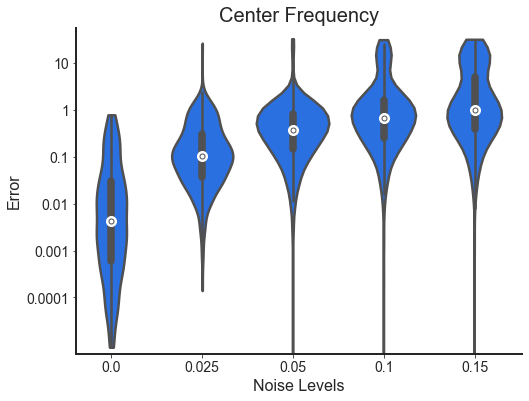

In [24]:
# Plot the error of peak center frequency reconstruction
plot_errors_violin(cf_errors, 'Center Frequency',
                   plt_log=True, y_label=None, ylim=[-5.2, 1.75],
                   yticks=[0.0001, 0.001, 0.01, 0.1, 1, 10],
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'cf_error'))

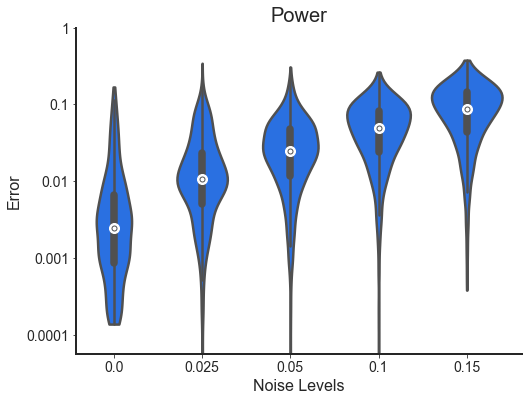

In [25]:
# Plot the error of peak power reconstruction
plot_errors_violin(pw_errors, 'Power',
                   plt_log=True, y_label=None, ylim=[-4.25, 0],
                   yticks=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'pw_error'))

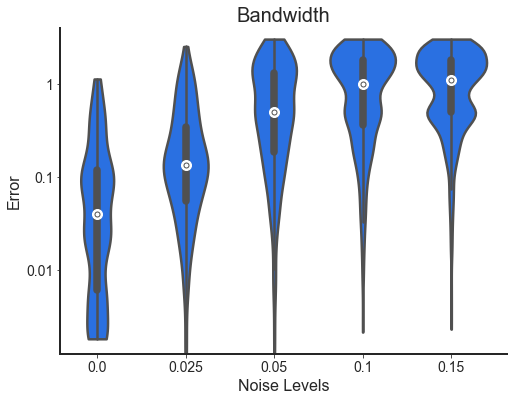

In [26]:
# Plot the error of peak bandwidth reconstruction
plot_errors_violin(bw_errors, 'Bandwidth',
                   plt_log=True, y_label=None, ylim=[-2.9, 0.6],
                   yticks=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'bw_error'))

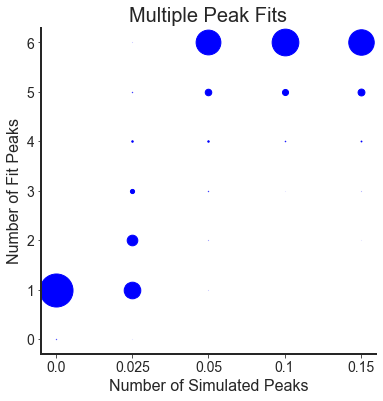

In [27]:
# Plot the number of peaks fit per condition
n_peak_counter = count_peak_conditions(n_fit_peaks, NLVS)
plot_n_peaks_bubbles(n_peak_counter, ms_val=15)

#### Aperiodic Components

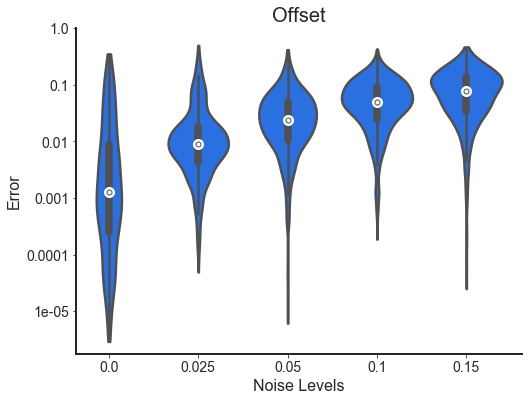

In [28]:
# Plot the error of aperiodic offset reconstruction
plot_errors_violin(off_errors, 'Offset',
                   plt_log=True, y_label=None, ylim=[-5.75, 0.01],
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'off_error'))

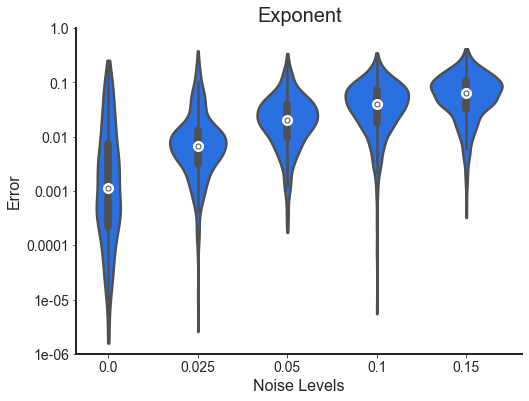

In [29]:
# Plot the error of aperiodic exponent reconstruction
plot_errors_violin(exp_errors, 'Exponent',
                   plt_log=True, y_label=None, ylim=[-6.0, 0.01],
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'exp_error'))

#### Goodness of Fit Measures

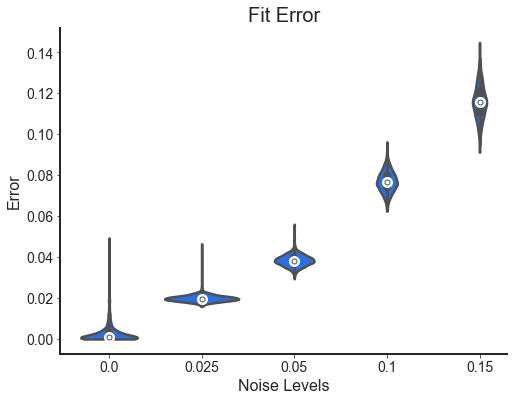

In [30]:
# Plot the amount of error across noise levels
plot_errors_violin(err_fits, 'Fit Error', plt_log=False,
                   y_label='Error',
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'model_error'))

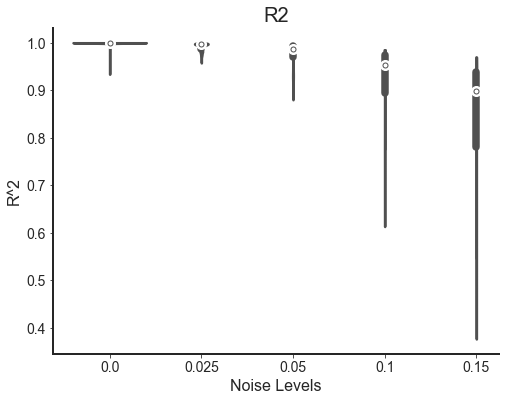

In [31]:
# Plot the goodness-of-fit (R^2) across noise levels
plot_errors_violin(r2_fits, 'R2', y_label='R^2', plt_log=False,
                   save_fig=SAVE_FIG, save_name=pjoin(FOLDER, 'model_r_squared'))

### Example FOOOF Fits

SimParams(aperiodic_params=[0, 1.0], periodic_params=[[16, 0.4, 2.0]], nlv=0.0)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          0.0013, 1.0004                                          
                                                                                                  
                             

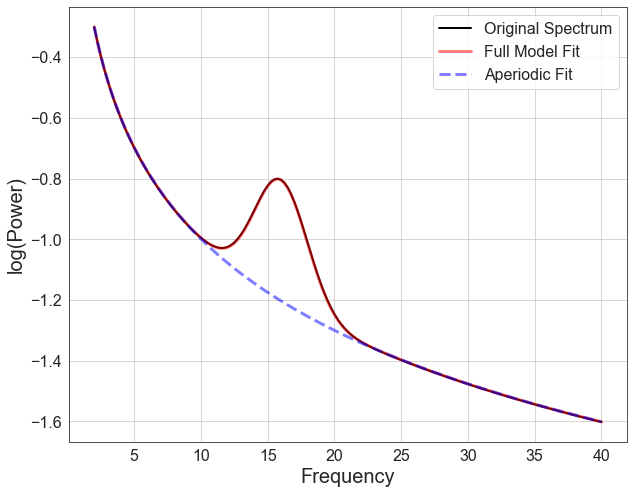

In [32]:
# Grab example cases - low noise
ind = 0
fm_nlv1 = fgs[0].get_fooof(ind, True)
print(sim_params[0][ind])
fm_nlv1.print_results()
fm_nlv1.plot(save_fig=SAVE_FIG, file_path=pjoin(FIGS_PATH, FOLDER), file_name='example_nlv1')

SimParams(aperiodic_params=[0, 2.0], periodic_params=[[11, 0.4, 2.0]], nlv=0.15)
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 2 - 40 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -0.0124, 2.0521                                          
                                                                                                  
                            

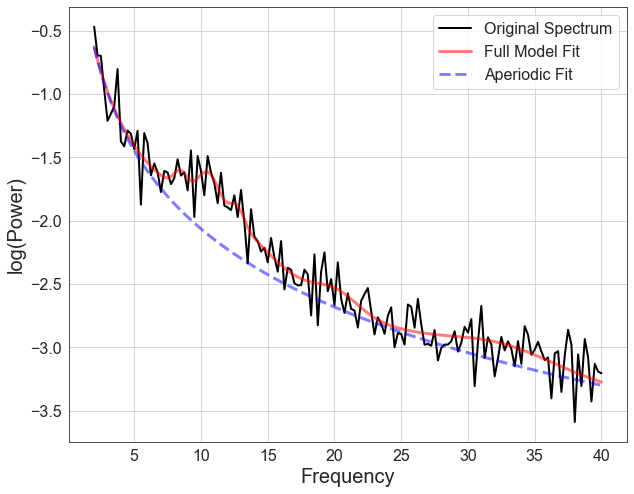

In [33]:
# Grab example cases - high noise
ind = 0
fm_nlv5 = fgs[-1].get_fooof(ind, True)
print(sim_params[-1][ind])
fm_nlv5.print_results()
fm_nlv5.plot(save_fig=SAVE_FIG, file_path=pjoin(FIGS_PATH, FOLDER), file_name='example_nlv5')